# Assignment 2 - Million Song Dataset Analysis using Spark
### Ally Hassell 

## Functions

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LinearSVC

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.recommendation import ALS

In [2]:
# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')
    
    
def calc_auroc(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)
    return auroc
    
    
# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

### Start Spark session

In [3]:
# Run this cell to start a spark session in this notebook

#start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)
start_spark(executor_instances=8, executor_cores=4, worker_memory=4, master_memory=4)

spark.ui.port,4799
spark.dynamicAllocation.enabled,false
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.app.name,aha199 (jupyter)
spark.sql.warehouse.dir,file:/users/home/aha199/spark-warehouse
spark.executor.id,driver
spark.executor.instances,8
spark.app.startTime,1686295579470
spark.driver.host,mathmadslinux2p.canterbury.ac.nz


In [4]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 128


### Question 1

#### a) Load data from summary, tasteprofile and attributes

In [5]:
# Main summary analysis data

# Read in
msd = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .load("hdfs:///data/msd/main/summary/analysis.csv.gz")
    #.limit(1000)
    .repartition(partitions)
)

# Cache
msd.cache()

# Schema
#msd.printSchema()

# Show result
show_as_html(msd, 5)

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id
0,22050,0c7cefa114077c3ff6154ca1044898b8,0.0,158.61506,0.073,0.0,0,0,0,0,...,1,0.370,-10.873,1,0.228,151.539,157.317,4,0.688,TROFPHI128F426BDD1
1,22050,d998527d7fea3fb039078201b6c0b0ca,0.0,308.42730,2.177,0.0,0,0,0,0,...,6,0.097,-10.315,1,0.294,308.427,120.762,4,0.915,TRAVPRK128F42797F6
2,22050,6328b1ebd0355d70917c2ba24899ce85,0.0,485.53751,0.073,0.0,0,0,0,0,...,10,0.717,-9.532,0,0.576,466.913,119.021,4,1.000,TRTFVSM128F4278458
3,22050,4573924a621867c4ac1fa55fee9e7670,0.0,228.15302,0.061,0.0,0,0,0,0,...,11,0.575,-5.000,0,0.618,222.441,120.801,4,1.000,TRDIITM128F42936DB
4,22050,c60bec4abeaa0c3eed31fcc0b25026d9,0.0,220.13342,0.000,0.0,0,0,0,0,...,9,0.915,-12.337,0,0.894,220.133,103.661,4,0.000,TRIAPUY128F4276228


In [6]:
# Attribute statistics data

# Read in
attr_stat = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "true")
    .load("hdfs:///data/msd/audio/statistics/sample_properties.csv.gz")
    #.limit(1000)
    .repartition(partitions)
)

# Show reasult
show_as_html(attr_stat, 5)

,track_id,title,artist_name,duration,7digita_Id,sample_bitrate,sample_length,sample_rate,sample_mode,sample_version,filesize
0,TRCOTAD128F42652E8,3. Gavotte I-II,The Academy of St. Martin in the Fields / Thur...,225.90649,2238900,128,30.136097,44100,1,1,481071
1,TRRAHAV12903D03FB7,Loving Her Was Easier Than Anything I'Ll Ever...,Country Gentlemen,200.09751,6749814,128,30.136035,22050,1,2,481070
2,TRBWFRH128EF3407A6,Sugar,Joe Louis Walker,381.23057,701631,128,60.219825,44100,1,1,961306
3,TRXMQYM128F4289C89,No One Needs To Know,Ozma,246.72608,1750237,64,30.224427,22050,1,2,240662
4,TRDMDHT128F426EDCA,Doors Open (Jd Twitch's Slotimo Mix),Trio Exklusiv,376.00608,2279787,64,60.338210,22050,1,2,480443


In [7]:
# Attribute data (mvd as example)

# Read in
attr_data_example = (
    spark.read.format("csv")
    .option("header", "false")
    .option("inferSchema", "true")
    .load("hdfs:///data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv")
    .repartition(partitions)
)

# Show results
show_as_html(attr_data_example, 5)
    
# Combine schema and tables
feature_data_example = (
    spark.read.format("csv")
    .option("header", "false")
    .option("inferSchema", "false")
    #.schema(schema)
    .load("hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv")
    .repartition(partitions)
)

# Show results
show_as_html(feature_data_example, 5)

,_c0,_c1
0,component_166,NUMERIC
1,component_24,NUMERIC
2,component_333,NUMERIC
3,component_172,NUMERIC
4,component_327,NUMERIC


,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c412,_c413,_c414,_c415,_c416,_c417,_c418,_c419,_c420,_c421
0,0.309303,0.224323,0.288287,0.143713,0.150684,0.155373,0.074267,0.123662,0.110893,0.140524,...,0.104845,0.112474,0.132654,0.435186,0.387418,0.203701,0.296773,0.149253,'TRFEAVK128F93494B0',None
1,0.752514,0.587999,0.504622,0.336905,0.352252,0.347537,0.309187,0.250602,0.310421,0.292083,...,0.26683,0.25655,0.207389,0.202214,0.203133,0.184543,0.185787,0.167705,'TRKCSXR128F42586EE',None
2,0.202814,0.276457,0.13123,0.122184,0.116236,0.089513,0.137836,0.088805,0.098284,0.073921,...,0.121095,0.160173,0.183588,0.282936,0.615897,0.463611,0.22829,0.171959,'TRGEFCS12903CE148E',None
3,0.89079,0.454388,0.376312,0.486778,0.448658,0.36429,0.408807,0.36039,0.363368,0.328222,...,0.17183,0.201941,0.25388,0.316312,0.235998,0.168598,0.190951,0.181169,'TRJUTYB128F9349A51',None
4,0.578945,0.428215,0.486412,0.462294,0.354322,0.280706,0.327443,0.266881,0.275254,0.337619,...,0.338613,0.340358,0.25693,0.286914,0.540762,0.488803,0.246727,0.2686,'TRDEJQI128F9324961',None


In [8]:
# Tasteprofile data

# Read in
tasteprofile = (
    spark.read.format("csv")
    .option("inferSchema", "false")
    .option("header", "false")
    .load("hdfs:///data/msd/tasteprofile/triplets.tsv")
    #.limit(1000)
    .repartition(partitions)
)

# Split into substrings
tasteprofile = tasteprofile.select(
    substring("_c0", 1, 40).alias("user"), 
    substring("_c0", 42, 18).alias("song"),
    substring("_c0", 61, 5).cast(IntegerType()).alias("play_count")
)

# Show reasult
show_as_html(tasteprofile, 5)

,user,song,play_count
0,ca052b86f7e4ad3358f4db1b7a4bc908a88f504c,SOYSJUV12A8C139DCE,1
1,01642c59756c9177d0d0db10a4fdbcac15e0cc1b,SOTWCDE12AB018909C,5
2,dacffc7c1648e46676bea80d46995182bbf4c137,SOLRGVL12A8C143BC3,1
3,f3750814f1a3c91b61da1190ec3be43b70134c69,SOSLCWQ12AB0182892,5
4,a289038d474b98edd3d21f01009567eef8f5b316,SOPSVIR12A8C138BB5,1


In [9]:
# Mismatched tasteprofile data

# Read in
mismatches = (
    spark.read.format("csv")
    .option("inferSchema", "false")
    .option("header", "false")
    .load("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
    #.limit(1000)
    .repartition(partitions)
)

# Split into substrings
mismatches = mismatches.select(
    substring("_c0", 9, 18).alias("song"), 
    substring("_c0", 27, 19).alias("track"), 
    substring("_c0", 47, 400).alias("artists")
)

# Split artists
mismatches = mismatches.select(
    F.trim("song").alias("song"),
    F.trim("track").alias("track"),
    F.trim(F.split(mismatches['artists'], ' != ').getItem(0)).alias('artist1'),
    F.trim(F.split(mismatches['artists'], ' != ').getItem(1)).alias('artist2')
)

# Verified mismatched
ver_mismatches = mismatches.filter(F.col("artist1") != '-')
unver_mismatches = mismatches.filter(F.col("artist1") == '-')

# Show result
show_as_html(ver_mismatches, 5)
show_as_html(unver_mismatches, 5)

,song,track,artist1,artist2
0,SOTCNZB12A8C140479,TRRLCRP128F4290E2D,Elefant - Vaer dig selv,Elephant - Be yourself_ Pompadour
1,SOZZXBG12AB0182473,TRLVJHW128F932AC4A,Benny Joy - If I Had You,Willie Gunn - I don't want nobody (praising ...
2,SOYQZQN12AB017C20F,TRHBQNC128F92EF3BD,"Jose Alberto \El Canario\"""" - Untitled",Mark Alexander Bromwich - Ghosts
3,SOZWOUM12AB017E50E,TRLTAHU128F92E317F,Spiriakos - U Spin Me (Mr. Timothy Club Mix),Cristal Snow - Pump It Up (Miika Kuisma & Mr...
4,SOGTNCD12A8AE478CF,TROJBMY12903CA1C86,Riddim Driven: Bondage - Showers Of Blessings,Saba - Zion Or Hell


,song,track,artist1,artist2
0,SOUSUMP12AB01831C6,TRCYLMB128F931E02C,-,Nirvana - Mr. Moustache
1,SOAGBCW12AB0183D8F,TRBHOXO128F932A739,-,Easy Star All-Stars - With a Little Dub From...
2,SOBSUMQ12A6701C788,TRHSILH128F425963E,-,Limp Bizkit - Livin' It Up
3,SOJREQO12A8C13A8BF,TRIEOMR128F42A08FC,-,Tori Amos - scarlet's walk
4,SOEPMBQ12AC4687D03,TRAMAVI12903D15CB7,-,Everly Brothers - Rockin' Alone


#### c) Count number of rows in each dataset

In [10]:
# Number of rows in each metadata table

print("Msd number of rows:", msd.count())
print("Attribute statistics number of rows:", attr_stat.count())
print("Taste number of rows:", tasteprofile.count())
print("Verified mismatch songs number of rows:", ver_mismatches.count())
print("Unverified mismatches songs number of rows:", mismatches.count())

Msd number of rows: 1000000
Attribute statistics number of rows: 992865
Taste number of rows: 48373586
Verified mismatch songs number of rows: 5752
Unverified mismatches songs number of rows: 19094


### Question 2

#### a) Filter out mismatched songs from tasteprofile

In [11]:
# Remove mismatched songs tasteprofile

# Initial number songs tasteprofile
orig_tasteprofile = tasteprofile.count()

# Anitjoin to remove mismatched
tasteprofile = tasteprofile.join(
        ver_mismatches,
        on="song",
        how="leftanti"
    )

# Number songs tasteprofile after removing mismatched
sec_tasteprofile = tasteprofile.count()

# Show result 
print("Taste number of rows after removing mismatched songs:", tasteprofile.count())
print("Number of tracks removed:", orig_tasteprofile - sec_tasteprofile)

Taste number of rows after removing mismatched songs: 47946099
Number of tracks removed: 427487


#### b) Audio feature automated datasets

In [12]:
# Load attributes data

# File names 
file_names = ['mvd',
              'rh',
              'rp',
              'ssd',
              'trh',
              'tssd']

# data type conversion
data_types = {"NUMERIC" : DoubleType(),
              "STRING" : StringType(),
              "String" : StringType()
             }

# Empty dict for attr datatables
attr_dict = {}

# Combine attr metadata schema and attr tables 
for file in file_names: 
    # Metadata table
    meta_data = (
        spark.read.format("csv")
        .option("inferSchema", "true")
        .load("hdfs:///data/msd/audio/attributes/msd-{}-v1.0.attributes.csv".format(file))
        .repartition(partitions)
    )
    
    # To pandas required for suther transforms
    meta_data = meta_data.toPandas()
    meta_data = meta_data[:-1]
    meta_data.loc[len(meta_data)] = ["track", "STRING"]
    
    # Schema for loop
    schema = StructType([
        StructField(row['_c0'], data_types[row['_c1']], True) for index, row in meta_data.iterrows()
    ])
    
    # Combine schema and tables
    data_table = (
        spark.read.format("csv")
        .option("header", "false")
        .option("inferSchema", "false")
        .schema(schema)
        .load("hdfs:///data/msd/audio/features/msd-{}-v1.0.csv".format(file))
        .repartition(partitions)
    )
    
    #data_table = data_table.withColumn("track", F.regexp_replace(F.col("track"), " \'", ''))
    data_table = data_table.withColumn("track", F.expr("substring(track, 2, length(track)-2)"))
    data_table = data_table.drop("instanceName")
    
    # Add to dict
    attr_dict[file] = data_table

# Pull out tables from dictionary
mvd_df = attr_dict['mvd']
rh_df = attr_dict['rh']
rp_df = attr_dict['rp']
ssd_df = attr_dict['ssd']
trh_df = attr_dict['trh']
tssd_df = attr_dict['tssd']

# Cache useful tables 
rh_df.cache()

# Show result
show_as_html(rh_df, 5)

,component_54,component_13,component_4,component_35,component_14,component_9,component_50,component_17,component_51,component_20,...,component_0,component_19,component_31,component_52,component_48,component_34,component_5,component_22,component_44,track
0,15.227225,9.789376,10.317020,9.361516,8.409826,7.097151,6.879580,5.627028,7.365947,7.279247,...,3.264271,2.465611,2.552484,1.936787,2.601962,1.995490,2.228514,2.356715,2.438025,TRAZJPD128F93365B5
1,13.037788,9.269262,9.457762,8.084110,8.211780,5.340538,3.887411,6.291280,4.142826,5.455870,...,1.791866,3.004530,2.445937,2.291046,3.416689,2.424951,4.446801,1.868987,2.478687,TRBWHMY128F421F4B2
2,7.541101,6.232885,9.184800,6.036807,5.284024,8.840779,6.449261,4.942939,5.610960,5.242342,...,2.596299,2.073980,2.183635,1.888544,1.786020,2.341531,1.908027,1.656925,2.122259,TRAHKFM128F931DAAA
3,13.386791,9.499845,10.292569,8.905760,7.073920,11.228704,8.329012,5.794269,6.118713,7.011688,...,2.273372,2.710970,1.738115,2.068370,2.069525,2.555547,1.647260,1.924862,3.552138,TRIDSOU128F425CCF3
4,6.448701,5.265174,5.407408,5.091500,4.133468,4.909250,3.374959,5.049198,3.509632,3.960549,...,1.769223,1.802900,1.919404,1.941045,1.690427,1.698414,1.642543,1.957182,1.891783,TRZVKKW128F930FB47


## Audio similarity

### Question 1

#### a) Descriptive statistics for an audio feature dataset

In [13]:
# Descriptive statistics

# Describe df
rh_stats = rh_df.describe()

# Show result
show_as_html(rh_stats)

,summary,component_54,component_13,component_4,component_35,component_14,component_9,component_50,component_17,component_51,...,component_0,component_19,component_31,component_52,component_48,component_34,component_5,component_22,component_44,track
0,count,994185,994185,994185,994185,994185,994185,994185,994185,994185,...,994185,994185,994185,994185,994185,994185,994185,994185,994185,994185
1,mean,10.747208130044205,8.804710263856325,7.545513634260221,6.632828271028027,6.130460207571027,5.867654698077321,5.436777560136192,5.082181781629172,5.028319062589963,...,1.9354112753028865,1.8581311572725387,1.831932789876129,1.807096174089329,1.770416327217771,1.726510606783446,1.6755190424759976,1.657649809285998,1.6280000241725634,None
2,stddev,4.745722803168796,3.6237424525424626,2.990341180856468,2.773977960095915,2.6341447273498804,2.449710559976115,2.2677504135614277,2.2016093670657844,2.311367754681679,...,1.2395172178005482,1.108285075327359,1.1081091745773528,1.113278820967916,1.0332090951752786,0.9682615966660072,0.9034204159613818,0.8563194022460766,0.7984806847634924,None
3,min,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,...,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,2.23E-4,TRAAAAK128F9318786
4,max,73.000064,50.474817,52.279847,63.014065,38.099166,33.066823,35.469324,41.502096,35.466233,...,46.776718,32.498975,32.19366,32.939718,34.348224,26.530401,28.34271,32.390553,24.881626,TRZZZZO128F428E2D4


In [14]:
# Compute descriptive statistics

rh_stats = (
    rh_df
    .select([col for col in rh_df.columns if col.startswith("c")])
    .describe()
    .toPandas()
    .set_index("summary")
    .rename_axis(None)
    .T
    .reset_index()
)

display(rh_stats)

,index,count,mean,stddev,min,max
0,component_54,994185,10.747208130044205,4.745722803168796,2.23E-4,73.000064
1,component_13,994185,8.804710263856323,3.623742452542464,2.23E-4,50.474817
2,component_4,994185,7.545513634260222,2.990341180856467,2.23E-4,52.279847
3,component_35,994185,6.632828271028029,2.773977960095915,2.23E-4,63.014065
4,component_14,994185,6.130460207571028,2.634144727349881,2.23E-4,38.099166
5,component_9,994185,5.867654698077322,2.449710559976115,2.23E-4,33.066823
6,component_50,994185,5.436777560136192,2.2677504135614286,2.23E-4,35.469324
7,component_17,994185,5.082181781629173,2.2016093670657835,2.23E-4,41.502096
8,component_51,994185,5.028319062589963,2.311367754681678,2.23E-4,35.466233
9,component_20,994185,4.804714586012665,2.184539766095407,2.23E-4,33.369625


In [15]:
# Correlation matrix

# Drop non-numeric column
rh_df_corr = rh_df.drop("component_328", "instanceName", "track")

# Vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=rh_df_corr.columns, outputCol=vector_col, handleInvalid = "skip")
df_vector = assembler.transform(rh_df_corr).select(vector_col)

# Correlation matrix
rh_corr = Correlation.corr(df_vector, vector_col, 'pearson')

# Convert correlation matrix to Pandas DataFrame
matrix = rh_corr.collect()[0][0]
corr_matrix_df = pd.DataFrame(data=matrix.toArray().tolist(), columns=rh_df_corr.columns, index=rh_df_corr.columns)


# Flatten the correlation matrix into a list of tuples
corr_list = [(column1, column2, corr) for i, column1 in enumerate(rh_df_corr.columns) for j, column2 in enumerate(rh_df_corr.columns) for corr in [matrix[i,j]] if i < j]

# Sort the list by correlation values in descending order
corr_list_sorted = sorted(corr_list, key=lambda x: x[2], reverse=True)

# Print the top 15 highest correlations
count_70 = 0
for column1, column2, corr in corr_list_sorted[:100]:
    if corr >= 0.70:
        print(f"{column1} and {column2}: {corr:.2f}")
        count_70 += 1
        
# Print the top 15 highest correlations
count_50 = 0
for column1, column2, corr in corr_list_sorted:
    if corr >= 0.50 and corr < 0.70:
        count_50 += 1
        
# Print the top 15 highest correlations
count_50_below = 0
for column1, column2, corr in corr_list_sorted:
    if corr < 0.50:
        count_50_below += 1

# How many  correlations at each bracket
print(f"Number of correlations with a value of 0.70 or higher: {count_70}")
print(f"Number of correlations with a value of 0.5 to 0.7: {count_50}")
print(f"Number of correlations with a value of less than 0.5: {count_50_below}")


component_25 and component_24: 0.78
component_27 and component_0: 0.78
component_35 and component_17: 0.77
component_14 and component_20: 0.77
component_7 and component_3: 0.77
component_56 and component_44: 0.77
component_39 and component_48: 0.76
component_11 and component_41: 0.76
component_13 and component_35: 0.76
component_45 and component_43: 0.76
component_10 and component_32: 0.76
component_28 and component_58: 0.75
component_18 and component_31: 0.75
component_15 and component_5: 0.75
component_13 and component_4: 0.75
component_40 and component_36: 0.75
component_54 and component_13: 0.75
component_16 and component_55: 0.75
component_30 and component_39: 0.75
component_49 and component_56: 0.74
component_51 and component_11: 0.74
component_20 and component_45: 0.74
component_8 and component_2: 0.74
component_35 and component_14: 0.74
component_38 and component_10: 0.73
component_21 and component_27: 0.72
component_4 and component_35: 0.72
component_17 and component_8: 0.72
c

In [16]:
# Choose a threshold and visualize which correlations are above the threshold 

# Array of correlations
correlations = matrix.toArray()

# Threshold
threshold = 0.70

# Display results 
display(HTML(pd.DataFrame(correlations > threshold).astype(int).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


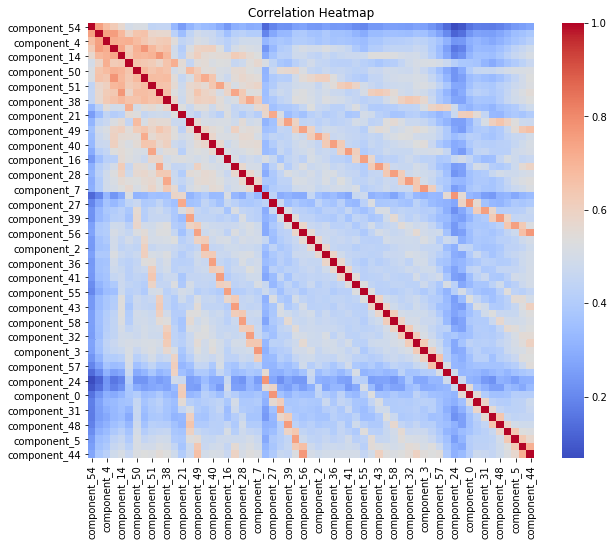

In [17]:
# Correlation matrix

# Drop non-numeric column
rh_df_corr = rh_df.drop("instanceName", "track")

# Vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=rh_df_corr.columns, outputCol=vector_col, handleInvalid = "skip")
df_vector = assembler.transform(rh_df_corr).select(vector_col)

# Correlation matrix
rh_corr = Correlation.corr(df_vector, vector_col)

# Heatmap correlation matrix 
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=rh_df_corr.columns, index=rh_df_corr.columns)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_df, cmap='coolwarm', annot=False, cbar=True)
plt.title('Correlation Heatmap')

# Save the figure
plt.savefig('correlation_heatmap.png')
plt.show()

#### b) Load MAGD dataset and visualise ditribution of genres for songs matched

In [18]:
# Genre data

# List of file names
file_genre = ["MAGD-genre", "MASD-style", "topMAGD-genre"]

# Empty genre dict
genre_dict = {}

# Read in file per file name
for file in file_genre:
    # Read in
    table = (
        spark.read.format("csv")
        .option("inferSchema", "false")
        .option("header", "false")
        .load("hdfs:///data/msd/genre/msd-{}Assignment.tsv".format(file))
        #.limit(1000)
        .repartition(partitions)
    )

    # Split into substrings
    table = table.select(
    substring("_c0", 1, 18).alias("track"), 
    substring("_c0", 20, 50).alias("genre")
    )

    # Trim spaces
    table = table.select(
        F.regexp_replace("track", " \'", '').alias("track"),
        F.regexp_replace("genre", " \'", '').alias("genre")
    )

    # Dictionary add
    genre_dict[file] = table

# Pull table from dict
genre = genre_dict["MAGD-genre"]
style = genre_dict["MASD-style"]
top_genre = genre_dict["topMAGD-genre"]

# Cache useful tables 
genre.cache()

# Show results
show_as_html(genre, 5)

,track,genre
0,TRYDCST128F424D848,International
1,TRXSPDH128F4228B86,Jazz
2,TRTTCDR12903CB8C60,Electronic
3,TRTXKVL128F930720C,Religious
4,TRUWUAP128F427DC2A,Electronic


In [19]:
# Genre visualization table

# Group by genre
multi_class_counts = genre.groupBy("genre").count()

# To df
multi_class_counts_df = multi_class_counts.toPandas()

# Show results 
show_as_html(multi_class_counts)

,genre,count
0,Children,477
1,New Age,4010
2,Holiday,200
3,Stage,1614
4,Electronic,41075
5,RnB,14335
6,Folk,5865
7,Pop_Rock,238786
8,Classical,556
9,Reggae,6946


(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07]), <a list of 9 Text xticklabel objects>)

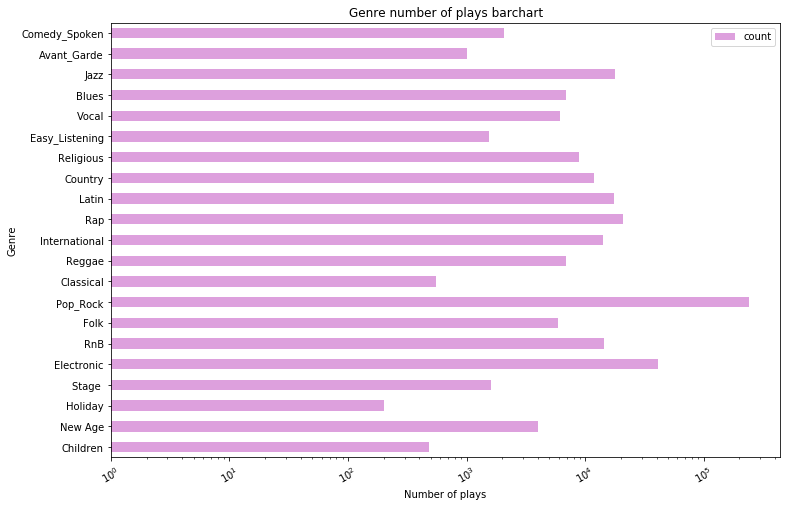

In [20]:
# Visualise with barchart and log axes

# Barchart 
bar_plot = multi_class_counts_df.plot(x='genre', y='count', rot=0, kind="barh", figsize=(12, 8), log=True, color=['Plum'])
plt.title("Genre number of plays barchart")
plt.xlabel("Number of plays")
plt.ylabel("Genre")
plt.xticks(rotation=30, horizontalalignment="center")

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 <a list of 7 Text xticklabel objects>)

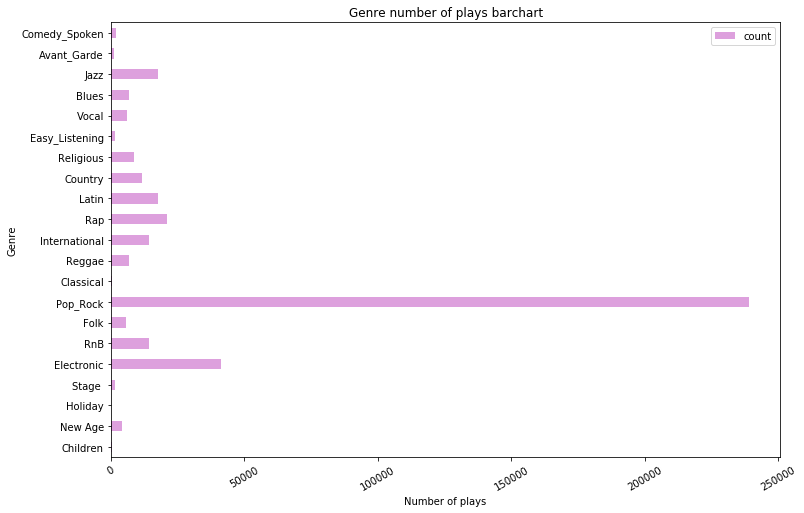

In [21]:
# Visualise with barcharts 

# Barchart 
bar_plot = multi_class_counts_df.plot(x='genre', y='count', rot=0, kind="barh", figsize=(12, 8), color=['Plum'])
plt.title("Genre number of plays barchart")
plt.xlabel("Number of plays")
plt.ylabel("Genre")
plt.xticks(rotation=30, horizontalalignment="center")

#### c) Merge genres with audio

In [22]:
# Join genre and attribute rh on track

# Join function
genre_rh = genre.join(
        rh_df,
        on='track',
        how='inner'
    )

# Drop mistake col
genre_rh = genre_rh.drop("instanceName")

# Cache result
genre_rh.cache()

# Show result
show_as_html(genre_rh, 5)

,track,genre,component_54,component_13,component_4,component_35,component_14,component_9,component_50,component_17,...,component_29,component_0,component_19,component_31,component_52,component_48,component_34,component_5,component_22,component_44
0,TRAAGTO128F1497E3C,Pop_Rock,11.850006,8.282049,8.111914,6.349772,8.503122,6.235452,4.950705,4.421822,...,1.056176,1.082580,0.902084,0.935158,1.109699,0.876004,1.029242,0.833649,0.817340,0.819396
1,TRAAZNZ128F429EF86,Pop_Rock,9.112286,7.777015,4.802561,3.748956,4.077620,3.213307,2.824780,2.504331,...,0.627488,0.642090,0.595800,0.561214,0.487454,0.568337,0.539015,0.498150,0.607965,0.530455
2,TRAAZOZ12903C9CABF,Pop_Rock,13.938556,12.864865,11.294593,6.964156,5.690866,7.626895,4.744560,5.325789,...,1.753204,1.987932,1.591097,1.993556,1.547708,1.702389,1.564517,1.616183,1.821583,1.883686
3,TRABGUX12903CD11FF,Rap,6.095115,4.244516,2.504957,2.729299,3.177206,1.916254,3.024634,2.333149,...,1.060702,0.981904,1.689696,1.584082,1.123915,0.868203,0.957071,1.082385,0.823081,0.736078
4,TRABHCK128F423E15A,International,7.301924,6.525263,7.101113,6.359811,5.523007,4.902787,4.443613,4.842408,...,1.272585,1.247688,1.868700,1.512678,1.188016,1.107385,1.366760,1.259869,1.378658,1.330882


### Question 2

#### a) Classification algorithms

#### Preprocessing

In [23]:
# Highly correlated variables 

# Average of multicolinearity columns
genre_rh_prep = genre_rh.withColumn("component_mean", ((F.col("component_4") + F.col("component_14") + F.col("component_50") + F.col("component_51") + F.col("component_38")) / lit(5)))

# Show results 
show_as_html(genre_rh_prep, 5)

,track,genre,component_54,component_13,component_4,component_35,component_14,component_9,component_50,component_17,...,component_0,component_19,component_31,component_52,component_48,component_34,component_5,component_22,component_44,component_mean
0,TRAAGTO128F1497E3C,Pop_Rock,11.850006,8.282049,8.111914,6.349772,8.503122,6.235452,4.950705,4.421822,...,1.082580,0.902084,0.935158,1.109699,0.876004,1.029242,0.833649,0.817340,0.819396,5.887725
1,TRAAZNZ128F429EF86,Pop_Rock,9.112286,7.777015,4.802561,3.748956,4.077620,3.213307,2.824780,2.504331,...,0.642090,0.595800,0.561214,0.487454,0.568337,0.539015,0.498150,0.607965,0.530455,3.249483
2,TRAAZOZ12903C9CABF,Pop_Rock,13.938556,12.864865,11.294593,6.964156,5.690866,7.626895,4.744560,5.325789,...,1.987932,1.591097,1.993556,1.547708,1.702389,1.564517,1.616183,1.821583,1.883686,6.584498
3,TRABGUX12903CD11FF,Rap,6.095115,4.244516,2.504957,2.729299,3.177206,1.916254,3.024634,2.333149,...,0.981904,1.689696,1.584082,1.123915,0.868203,0.957071,1.082385,0.823081,0.736078,3.018241
4,TRABHCK128F423E15A,International,7.301924,6.525263,7.101113,6.359811,5.523007,4.902787,4.443613,4.842408,...,1.247688,1.868700,1.512678,1.188016,1.107385,1.366760,1.259869,1.378658,1.330882,5.297225


In [24]:
# Vectorize features

# Assemble features into array
assembler = VectorAssembler(
    inputCols=[col for col in genre_rh_prep.columns if col.startswith("c")],
    outputCol="features"
)
df_grh = assembler.transform(genre_rh_prep)

# Select cols we want
df_grh = df_grh.select(
    F.col('track'),
    F.col('genre'),
    F.col('features'),
)

# Show results 
show_as_html(df_grh, 5)

,track,genre,features
0,TRAAGTO128F1497E3C,Pop_Rock,"[11.850006, 8.282049, 8.111914, 6.349772, 8.50..."
1,TRAAZNZ128F429EF86,Pop_Rock,"[9.112286, 7.777015, 4.802561, 3.748956, 4.077..."
2,TRAAZOZ12903C9CABF,Pop_Rock,"[13.938556, 12.864865, 11.294593, 6.964156, 5...."
3,TRABGUX12903CD11FF,Rap,"[6.095115, 4.244516, 2.504957, 2.729299, 3.177..."
4,TRABHCK128F423E15A,International,"[7.301924, 6.525263, 7.101113, 6.359811, 5.523..."


In [25]:
# Encode label

# Encoding dict
encode_dict_electronic = {'Electronic': 1}

# Function create label 
def encode_label_electronic(genre_name):
    label = 0
    for genre in encode_dict_electronic:
        if genre_name == genre:
            label = 1
    return label

# Make into user-defined function
encode_label_electronic = F.udf(encode_label_electronic, IntegerType())

# Label genre
data_grh = df_grh.select(
    F.col('track'),
    encode_label_electronic(F.col('genre')).alias('label'),
    F.col('features')
)

# Filter to ensure id is specified
data_grh = data_grh.filter(F.col('track').isNotNull()).dropDuplicates(subset=['track'])
print(f'Number of rows in genre_rh: {data_grh.count()}')

# Show results
show_as_html(data_grh, 5)

Number of rows in genre_rh: 420357


,track,label,features
0,TRAAGTO128F1497E3C,0,"[11.850006, 8.282049, 8.111914, 6.349772, 8.50..."
1,TRAAZNZ128F429EF86,0,"[9.112286, 7.777015, 4.802561, 3.748956, 4.077..."
2,TRAAZOZ12903C9CABF,0,"[13.938556, 12.864865, 11.294593, 6.964156, 5...."
3,TRABGUX12903CD11FF,0,"[6.095115, 4.244516, 2.504957, 2.729299, 3.177..."
4,TRABHCK128F423E15A,0,"[7.301924, 6.525263, 7.101113, 6.359811, 5.523..."


#### b) Class balance

In [26]:
# Class imbalance calcs 

# Counts
total_count = data_grh.count()
pos_label_count = data_grh.groupBy().sum().collect()[0][0]
neg_label_count = total_count - pos_label_count

# Resample calc
class_bal = pos_label_count/neg_label_count

# Print results
print(f"Total number rows: {total_count}")
print(f"Positive class: {pos_label_count}")
print(f"Negative class: {neg_label_count}")
print(f"Class balance: {class_bal:.2}")

Total number rows: 420357
Positive class: 40688
Negative class: 379669
Class balance: 0.11


#### c) Split data with stratified random resampling

In [27]:
# Exact stratification 

# Tempory table with random
temp = (
    data_grh
    .withColumn("track", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

# Training
training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < neg_label_count * 0.8)) |  
    ((F.col("label") == 1) & (F.col("row") < pos_label_count    * 0.8))    
)
training.cache()

# Test
test = temp.join(training, on="track", how="left_anti")
test.cache()

# Tidy up train/test
training = training.drop("track", "random", "row")
test = test.drop("track", "random", "row")

# Ensure datasets are cached
data_grh.cache()
training.cache()
test.cache()

# Show results
print_class_balance(data_grh, "data_grh")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: data_grh
total:   420357
counts:
   label   count     ratio
0      0  379669  0.903206
1      1   40688  0.096794

dataset: training
total:   336285
counts:
   label   count     ratio
0      0  303735  0.903207
1      1   32550  0.096793

dataset: test
total:   84072
counts:
   label  count     ratio
0      0  75934  0.903202
1      1   8138  0.096798



In [28]:
# Counts for upsampling / downsampling

counts = {
    label: count for label, count in training.groupBy("label").count().collect()
}
print(counts) 

{0: 303735, 1: 32550}


In [29]:
# Upsampling via poisson random sampling

# Bounds
count_lower_bound = 150000
count_upper_bound = 180000

# Random resample function
def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
            return [1]
        else:
            return []

    return [1]  

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)
training_resampled = (
    training
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("label"), F.col("rand")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
    )
    .drop("sample")
)

# Print new class balances
print_class_balance(training_resampled, "training (resampled)")

dataset: training (resampled)
total:   329354
counts:
   label   count     ratio
0      0  179674  0.545535
1      1  149945  0.455270



#### d) Train model

In [30]:
# Logistic regression 

# Train model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_resampled)

# Predictions
lr_pred = lr_model.transform(test)

In [31]:
# SVM

# Create SVM classifier
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Train model
lsvc_model = lsvc.fit(training_resampled)

# Predictions
lsvm_pred = lsvc_model.transform(test)

In [32]:
# Gradient boosted trees

# Preprocessing for gradient boosted
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(training_resampled)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(training_resampled)

# create gradient boosted trees classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Pipeline
gb_pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model
gb_model = gb_pipeline.fit(training_resampled)

# Predictions
gb_pred = gb_model.transform(test)

#### e) Performance

In [33]:
# Logistic regression performance

# Show results
print_metrics(lr_pred)

metrics for custom threshold

threshold: 0.5

total:     84072

nP actual: 8138
nN actual: 75934

nP:        18893
nN:        65179

TP         5127
FP         13766
FN         3011
TN         62168

precision: 0.27137035
recall:    0.63000737
accuracy:  0.80044486

auroc:     0.79067686



In [34]:
# SVM performance

# Coefficients
print("Coefficients: " + str(lsvc_model.coefficients))
print("Intercept: " + str(lsvc_model.intercept))

# Show results
print_metrics(lsvm_pred)

Coefficients: [-0.03098317453097507,-0.04403193268771816,-0.019855660595306805,-0.05974182108960241,-0.05266827481258445,-0.004462875761642708,-0.013284374677338378,-0.034328548791518684,-0.025845298946996623,-0.026802487701017213,-0.026185533636711944,0.020953314554653393,0.032166646205666054,0.002706783233618475,-0.008751676613243324,-0.006550919341741728,-0.010802386242142801,-0.004705660486634721,0.019735977512291718,-0.0062705967651943365,-0.00822250341819219,-0.005055289439705834,-0.009587546662050516,0.058225576918454036,0.03883829915713305,0.02006146680291405,0.01655263671590021,-0.0021339533380351676,-0.004168141406347047,0.00010156103922621868,-0.001586858753101745,-0.006175292917975746,-0.003187951985598967,-0.0037202815050081804,-0.00416235730215571,0.029319917428602373,0.021062447614639,-0.003459401280400488,-0.002007657333106119,-0.004330791726346897,-0.000891921077831912,-0.00013105483565800552,-0.0012812023465794613,-0.002903128261755626,-0.005049289461481299,0.03499551

In [35]:
# Gradient boosted trees

# Show results
print_metrics(gb_pred)

metrics for custom threshold

threshold: 0.5

total:     84072

nP actual: 8138
nN actual: 75934

nP:        14445
nN:        69627

TP         4760
FP         9685
FN         3378
TN         66249

precision: 0.32952579
recall:    0.58491030
accuracy:  0.84462128

auroc:     0.80981513



### Question 3

#### a) Hyper-parameters of each model

In [36]:
# Logistic regression parameters
lr_param = LogisticRegression.__init__
lr_param 

<function pyspark.ml.classification.LogisticRegression.__init__(self, *, featuresCol='features', labelCol='label', predictionCol='prediction', maxIter=100, regParam=0.0, elasticNetParam=0.0, tol=1e-06, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol='probability', rawPredictionCol='rawPrediction', standardization=True, weightCol=None, aggregationDepth=2, family='auto', lowerBoundsOnCoefficients=None, upperBoundsOnCoefficients=None, lowerBoundsOnIntercepts=None, upperBoundsOnIntercepts=None, maxBlockSizeInMB=0.0)>

In [37]:
# LSVM param 
lsvm_param = LinearSVC.__init__
lsvm_param

<function pyspark.ml.classification.LinearSVC.__init__(self, *, featuresCol='features', labelCol='label', predictionCol='prediction', maxIter=100, regParam=0.0, tol=1e-06, rawPredictionCol='rawPrediction', fitIntercept=True, standardization=True, threshold=0.0, weightCol=None, aggregationDepth=2, maxBlockSizeInMB=0.0)>

In [38]:
# Gradient boosted trees param
gbt_param = GBTClassifier.__init__
gbt_param 

<function pyspark.ml.classification.GBTClassifier.__init__(self, *, featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType='logistic', maxIter=20, stepSize=0.1, seed=None, subsamplingRate=1.0, impurity='variance', featureSubsetStrategy='all', validationTol=0.01, validationIndicatorCol=None, leafCol='', minWeightFractionPerNode=0.0, weightCol=None)>

#### b) Tune best model

In [73]:
# Gradient boosted trees tuning

# Preprocessing for gradient boosted
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(training_resampled)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(training_resampled)

# create gradient boosted trees classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features")

# Grid tuning param
gb_param_grid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 7, 10])
             .addGrid(gbt.maxBins, [10, 32, 40])
             .addGrid(gbt.maxIter, [10, 20, 30])
             .addGrid(gbt.stepSize, [0.5, 0.1])
             .build())

# Cross validation 
cross_validator = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gb_param_grid,
    evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC'),
    numFolds=3)

# Call param and cv
gb_cv_model = cross_validator.fit(training_resampled)

# Predictions cv
gb_cv_pred = gb_cv_model.transform(test)

# Show results
print(f'hyperparameters selected')
print(f'')
print(f'Max depth: {gb_cv_model.bestModel.getMaxDepth()}')
print(f'Max bins: {gb_cv_model.bestModel.getMaxBins()}')
print(f'Max iterations: {gb_cv_model.bestModel.getMaxIter()}')
print(f'')
print_metrics(gb_cv_pred)

hyperparameters selected

Max depth: 10
Max bins: 40
Max iterations: 20

metrics for custom threshold

threshold: 0.5

total:     84072

nP actual: 8138
nN actual: 75934

nP:        13358
nN:        70714

TP         4769
FP         8589
FN         3369
TN         67345

precision: 0.35701452
recall:    0.58601622
accuracy:  0.85776477

auroc:     0.80055128



### Question 4

#### b) Genre column into integer index

In [39]:
# Genre dict

# Genres
genres = list(df_grh.select('genre').distinct().collect())

# Encoding dict
encode_dict_genres = {}
for i in range(0, len(genres)):
    genre = genres[i][0]
    encode_dict_genres[genre] = i
    
encode_dict_genres

{'Children': 0,
 'New Age': 1,
 'Holiday': 2,
 'Stage ': 3,
 'Electronic': 4,
 'RnB': 5,
 'Folk': 6,
 'Pop_Rock': 7,
 'Classical': 8,
 'Reggae': 9,
 'International': 10,
 'Rap': 11,
 'Latin': 12,
 'Country': 13,
 'Religious': 14,
 'Easy_Listening': 15,
 'Vocal': 16,
 'Blues': 17,
 'Jazz': 18,
 'Avant_Garde': 19,
 'Comedy_Spoken': 20}

In [40]:
# Encode genres

# Function create label 
def encode_label(genre_name):
    label = 0
    for genre in encode_dict_genres:
        if genre_name == genre:
            label = encode_dict_genres[genre]
    return label

# Make into user-defined function
encode_label = F.udf(encode_label, IntegerType())

# Label genre
data_genre_long = df_grh.select(
    F.col('track'),
    F.col('genre'),
    encode_label(F.col('genre')).alias('label'),
    F.col('features')
)

# Show results 
show_as_html(data_genre_long, 5)

,track,genre,label,features
0,TRAAGTO128F1497E3C,Pop_Rock,7,"[11.850006, 8.282049, 8.111914, 6.349772, 8.50..."
1,TRAAZNZ128F429EF86,Pop_Rock,7,"[9.112286, 7.777015, 4.802561, 3.748956, 4.077..."
2,TRAAZOZ12903C9CABF,Pop_Rock,7,"[13.938556, 12.864865, 11.294593, 6.964156, 5...."
3,TRABGUX12903CD11FF,Rap,11,"[6.095115, 4.244516, 2.504957, 2.729299, 3.177..."
4,TRABHCK128F423E15A,International,10,"[7.301924, 6.525263, 7.101113, 6.359811, 5.523..."


In [41]:
# Select relevant columns 

# Label genre
data_genre = data_genre_long.select(
    F.col('track'),
    F.col('label'),
    F.col('features')
)

# Show results 
show_as_html(data_genre, 5)

,track,label,features
0,TRAAGTO128F1497E3C,7,"[11.850006, 8.282049, 8.111914, 6.349772, 8.50..."
1,TRAAZNZ128F429EF86,7,"[9.112286, 7.777015, 4.802561, 3.748956, 4.077..."
2,TRAAZOZ12903C9CABF,7,"[13.938556, 12.864865, 11.294593, 6.964156, 5...."
3,TRABGUX12903CD11FF,11,"[6.095115, 4.244516, 2.504957, 2.729299, 3.177..."
4,TRABHCK128F423E15A,10,"[7.301924, 6.525263, 7.101113, 6.359811, 5.523..."


#### c) Multiclass model

In [42]:
# Multiclass info

# Multiclass counts
multi_class_counts = data_genre_long.groupBy("genre").count()

# Show results
show_as_html(multi_class_counts)

,genre,count
0,Children,463
1,New Age,3993
2,Holiday,200
3,Stage,1612
4,Electronic,40688
5,RnB,14314
6,Folk,5789
7,Pop_Rock,237453
8,Classical,555
9,Reggae,6909


In [43]:
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    data_genre
    .withColumn("track", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    data_genre
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

print(counts)

training_genre = temp
for label in labels:
    training_genre = training_genre.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training_genre.cache()

test_genre = temp.join(training_genre, on="track", how="left_anti")
test_genre.cache()

training_genre = training_genre.drop("track", "random", "row")
test_genre = test_genre.drop("track", "random", "row")

print_class_balance(data_genre, "data_genre")
print_class_balance(training_genre, "training_genre")
print_class_balance(test_genre, "test_genre")

{14: 8776, 11: 20873, 7: 237453, 8: 555, 0: 463, 5: 14314, 2: 200, 19: 1009, 12: 17491, 10: 14192, 3: 1612, 9: 6909, 4: 40688, 13: 11693, 17: 6800, 15: 1535, 18: 17770, 1: 3993, 20: 2063, 6: 5789, 16: 6182}
dataset: data_genre
total:   420360
counts:
    label   count     ratio
0      14    8776  0.020877
1       7  237453  0.564880
2      11   20873  0.049655
3       8     555  0.001320
4       0     463  0.001101
5       5   14314  0.034052
6       2     200  0.000476
7      19    1009  0.002400
8      12   17491  0.041610
9      10   14192  0.033762
10      3    1612  0.003835
11      9    6909  0.016436
12      4   40688  0.096793
13     13   11693  0.027817
14     17    6800  0.016177
15     15    1535  0.003652
16     18   17770  0.042273
17      1    3993  0.009499
18     20    2063  0.004908
19      6    5789  0.013772
20     16    6182  0.014706

dataset: training_genre
total:   336276
counts:
    label   count     ratio
0      14    7020  0.020876
1       7  189962  0.564899


In [44]:
# Counts for upsampling / downsampling

# Counts in dictionary
counts = {
    label: count for label, count in training_genre.groupBy("label").count().collect()
}
print(counts)

# Find average of classes 
sum_count = 0
for key, item in counts.items():
    sum_count += item

average_classes = sum_count/len(counts)
print(f"Average of classes is: {average_classes:.0f}")

{14: 7020, 7: 189962, 11: 16698, 0: 370, 8: 443, 5: 11451, 2: 159, 19: 807, 12: 13992, 10: 11353, 3: 1289, 9: 5527, 4: 32550, 13: 9354, 17: 5439, 15: 1227, 18: 14215, 1: 3194, 20: 1650, 6: 4631, 16: 4945}
Average of classes is: 16013


In [45]:
# Upsampling via poisson random sampling

# Bounds
count_lower_bound = 12000
count_upper_bound = 20000

# Random resample function
def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
            return [1]
        else:
            return []

    return [1]  

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)

# Training table with udf
training_genre = (
    training_genre
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("label"), F.col("rand")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
    )
    .drop("sample")
)

# Print new class balances
print_class_balance(training_genre, "training (resampled)")

dataset: training (resampled)
total:   277264
counts:
    label  count     ratio
0      14  12093  0.043615
1       7  19958  0.071982
2      11  16698  0.060224
3       0  12165  0.043875
4       8  11950  0.043100
5       5  11994  0.043258
6       2  12045  0.043442
7      19  12089  0.043601
8      12  13992  0.050465
9      10  11996  0.043266
10      3  12132  0.043756
11      9  12059  0.043493
12      4  20008  0.072162
13     13  11962  0.043143
14     17  12060  0.043496
15     15  12158  0.043850
16     18  14215  0.051269
17      1  11908  0.042948
18     20  12219  0.044070
19      6  12028  0.043381
20     16  12178  0.043922



In [46]:
# Counts for upsampling / downsampling

counts = {
    label: count for label, count in training_genre.groupBy("label").count().collect()
}
print(counts)

{14: 11995, 7: 19958, 11: 16698, 0: 12183, 8: 12082, 5: 12046, 2: 12045, 19: 12066, 12: 13992, 10: 11996, 3: 12204, 9: 12018, 4: 20008, 13: 11960, 17: 11917, 15: 12018, 18: 14215, 1: 11952, 20: 12287, 6: 11965, 16: 12006}


In [48]:
# Logistic regression multiclass

# Train model
lr_multi = LogisticRegression(featuresCol='features', labelCol='label')

lr_model_multi = lr_multi.fit(training_genre)

# Predictions
lr_pred_multi = lr_model_multi.transform(test_genre)

In [49]:
# Random forest multiclass performance

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')

# Calculate precision and recall
macro_precision = evaluator.evaluate(lr_pred_multi, {evaluator.metricName: "weightedPrecision"})
macro_recall = evaluator.evaluate(lr_pred_multi, {evaluator.metricName: 'weightedRecall'})

# Print macro results
print(f'Macro-precision: {macro_precision:.4f}')
print(f'Macro-recall: {macro_recall:.4f}')
print(f"")

# Calculate and print micro-precision results
micro_precision_list = []
print("Micro-precision:")
for key, value in encode_dict_genres.items():
    micro_precision = evaluator.evaluate(lr_pred_multi, {evaluator.metricName: 'precisionByLabel', evaluator.metricLabel: value})
    print(f"{key}: {micro_precision:.4f}")
    micro_precision_list.append(micro_precision)

# Calculate and print micro-precision results
micro_recall_list = []
print(f"")
print("Micro-recall:")
for key, value in encode_dict_genres.items():
    micro_recall = evaluator.evaluate(lr_pred_multi, {evaluator.metricName: 'recallByLabel', evaluator.metricLabel: value})
    print(f"{key}: {micro_recall:.4f}")
    micro_recall_list.append(micro_recall)

Macro-precision: 0.5123
Macro-recall: 0.3013

Micro-precision:
Children: 0.0064
New Age: 0.0393
Holiday: 0.0019
Stage : 0.0465
Electronic: 0.2790
RnB: 0.1073
Folk: 0.0590
Pop_Rock: 0.7740
Classical: 0.0073
Reggae: 0.1311
International: 0.1017
Rap: 0.3862
Latin: 0.1508
Country: 0.1180
Religious: 0.0664
Easy_Listening: 0.0116
Vocal: 0.0918
Blues: 0.0636
Jazz: 0.1115
Avant_Garde: 0.0147
Comedy_Spoken: 0.0397

Micro-recall:
Children: 0.1935
New Age: 0.0651
Holiday: 0.1707
Stage : 0.4520
Electronic: 0.4925
RnB: 0.0454
Folk: 0.0820
Pop_Rock: 0.3374
Classical: 0.1964
Reggae: 0.3090
International: 0.0063
Rap: 0.6357
Latin: 0.1283
Country: 0.1586
Religious: 0.0786
Easy_Listening: 0.0292
Vocal: 0.1956
Blues: 0.0713
Jazz: 0.0793
Avant_Garde: 0.2772
Comedy_Spoken: 0.2252


In [50]:
# Genre metrics in a table

# Add new columns with precision and recall to genre table
multi_metrics = multi_class_counts.toPandas()
multi_metrics["recall"] = micro_recall_list
multi_metrics["precision"] = micro_precision_list

# Show results 
multi_metrics

,genre,count,recall,precision
0,Children,463,0.193548,0.006356
1,New Age,3993,0.065081,0.039305
2,Holiday,200,0.170732,0.001855
3,Stage,1612,0.452012,0.046467
4,Electronic,40688,0.492504,0.279031
5,RnB,14314,0.045407,0.107349
6,Folk,5789,0.082038,0.058970
7,Pop_Rock,237453,0.337369,0.774010
8,Classical,555,0.196429,0.007343
9,Reggae,6909,0.308973,0.131062


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

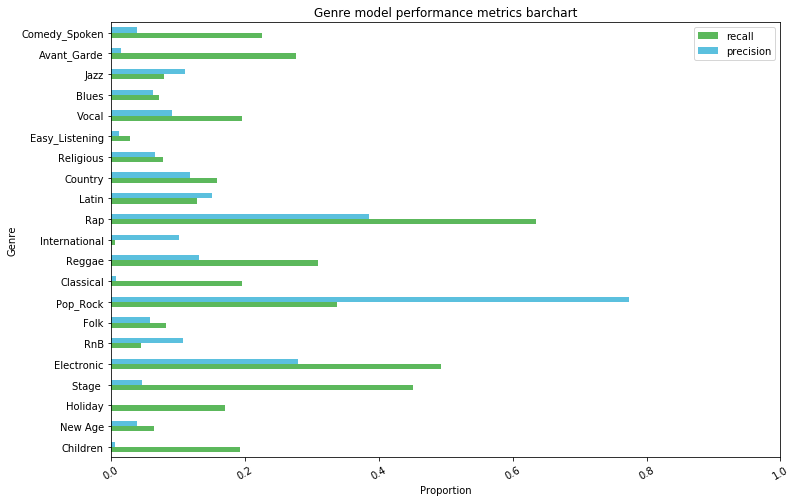

In [51]:
# Class balance, recall and precision plot xxx

# Visualise with barcharts 

# Barchart 
metrics_bar_plot = multi_metrics.plot(x='genre', y=['recall', 'precision'], rot=0, kind="barh", figsize=(12, 8), color=['#5cb85c','#5bc0de','#d9534f'])
plt.title("Genre model performance metrics barchart")
plt.xlabel("Proportion")
plt.ylabel("Genre")
plt.xlim([0, 1])
plt.xticks(rotation=30, horizontalalignment="center")

## Song reccomendations

### Question 1

#### a) Number of unique users and songs

In [52]:
# Count distinct num per column 

# Count
num_users = tasteprofile.select('user').distinct().count()
num_songs = tasteprofile.select('song').distinct().count()

# Show results 
print(f'Number of unique users: {num_users}')
print(f'Number of unique songs: {num_songs}')

Number of unique users: 1019318
Number of unique songs: 382173


#### b) Active user

In [53]:
# User sum songs

# Sum by listener
user_num_songs = (
    tasteprofile
    .groupBy(["user"])  
    .agg(
        F.sum(F.col("play_count")).cast(IntegerType()).alias("sum_plays")
    )
  .sort(F.desc("sum_plays"))
)

show_as_html(user_num_songs, 5)

,user,sum_plays
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13106
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9619
2,3fa44653315697f42410a30cb766a4eb102080bb,8210
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,6943
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6468


In [54]:
# Most active listener

# Active listener
active_id = user_num_songs.collect()[0][0]
active_plays = user_num_songs.collect()[0][1]

# Active user dataframe
active_data = tasteprofile.filter(F.col('user') == active_id)

# Count number of unique songs
active_distinct_songs = active_data.select('song').distinct().count()

# Percentage of dataset songs
active_perc_songs = active_distinct_songs/(num_songs/100)

# Show results 
print('Active user')
print(f'Total listens: {active_plays}')
print(f'Total songs: {active_distinct_songs}')
print(f'Percentage of all songs listened to: {active_perc_songs:.3f}')

Active user
Total listens: 13106
Total songs: 199
Percentage of all songs listened to: 0.052


#### c) Song popularity and user activity

In [55]:
# Sum by listener

# Group by song and sum plays
song_popularity = (
    tasteprofile
    .groupBy(["song"])  
    .agg(
        F.sum(F.col("play_count")).cast(IntegerType()).alias("sum_plays")
    )
  .sort(["sum_plays"])
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a08f70da0>]],
      dtype=object)

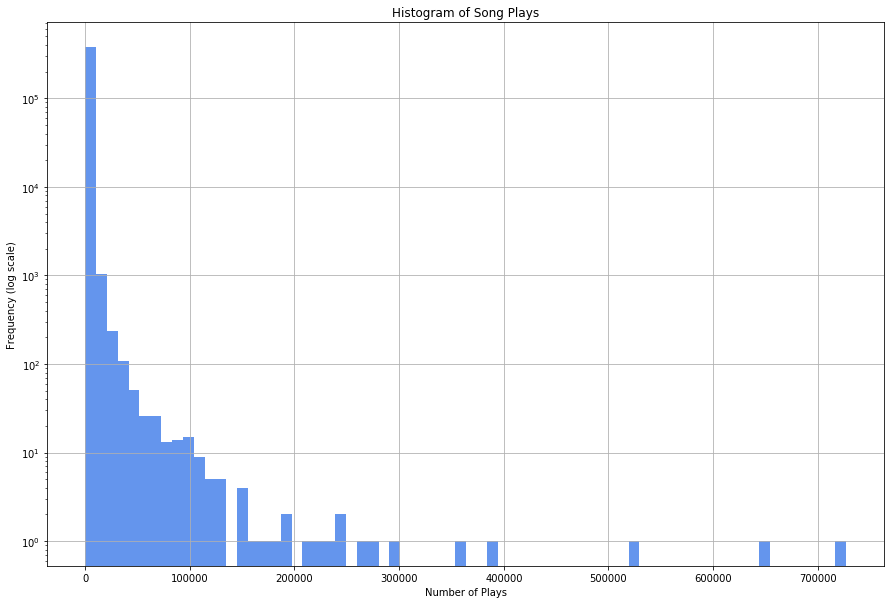

In [56]:
# Histogram song plays

# Histogram
song_hist = song_popularity.toPandas().hist(column='sum_plays', bins=70, color="cornflowerblue", log=True, figsize=(15, 10))

# Set title and labels
plt.title("Histogram of Song Plays")
plt.xlabel("Number of Plays")
plt.ylabel("Frequency (log scale)")

# Show plot
song_hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a08f9b438>]],
      dtype=object)

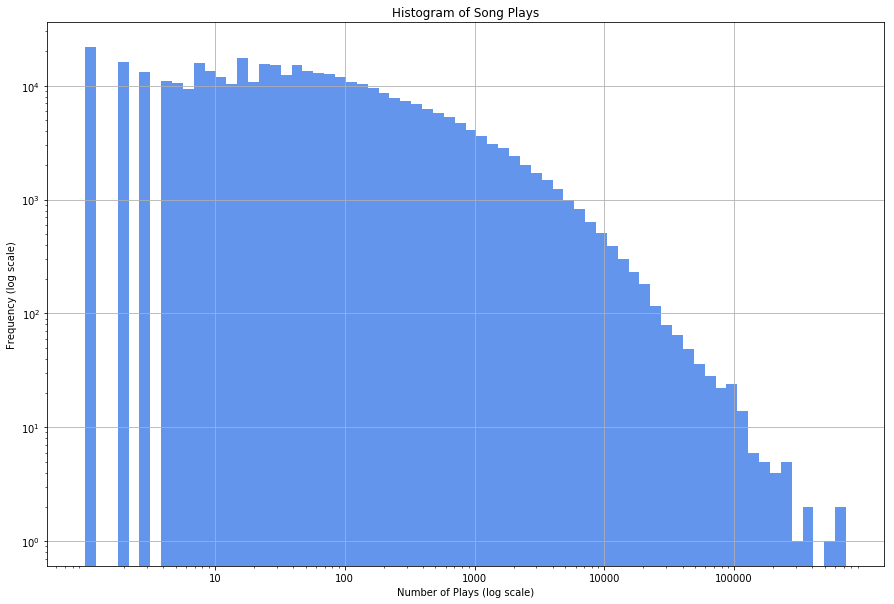

In [57]:
# Histogram song plays

# User-song hist
song_popularity_pd = song_popularity.toPandas()

# Calculate the logarithmic bin edges
log_bins = np.logspace(np.log10(song_popularity_pd['sum_plays'].min()), np.log10(song_popularity_pd['sum_plays'].max()), num=71)

# Histogram
song_hist = song_popularity_pd.hist(column='sum_plays', bins=log_bins, color="cornflowerblue", log=True, figsize=(15, 10))

# Set title and labels
plt.title("Histogram of Song Plays")
plt.xlabel("Number of Plays (log scale)")
plt.ylabel("Frequency (log scale)")

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set custom tick locations and labels on the x-axis
x_ticks = [10, 100, 1000, 10000, 100000]
x_tick_labels = [str(tick) for tick in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

# Show plot
song_hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a01f3ab70>]],
      dtype=object)

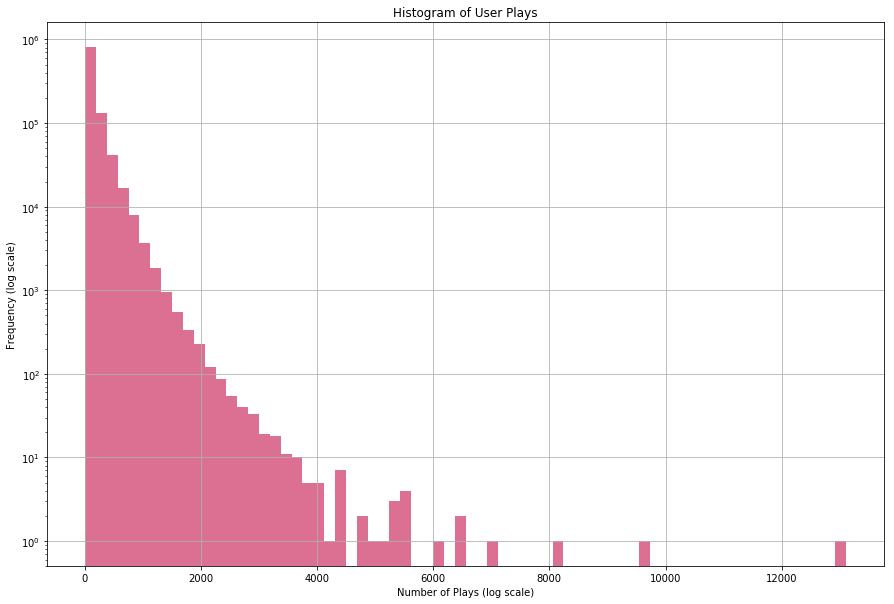

In [58]:
# Histogram song plays

# Histogram
user_hist = user_num_songs.toPandas().hist(column='sum_plays', bins=70, color="palevioletred", log=True, figsize=(15, 10))

# Set title and labels
plt.title("Histogram of User Plays")
plt.xlabel("Number of Plays (log scale)")
plt.ylabel("Frequency (log scale)")

# Show plot
user_hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a08f702b0>]],
      dtype=object)

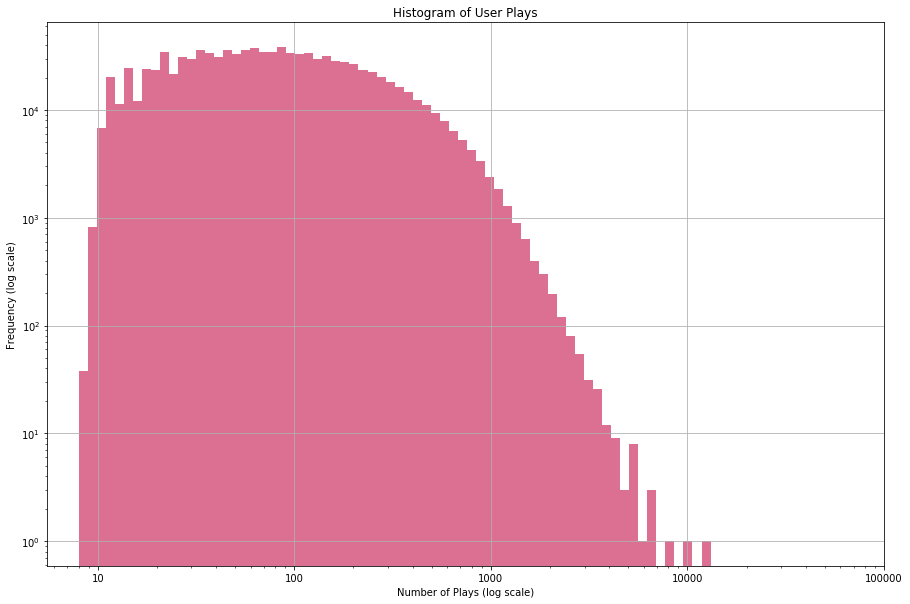

In [59]:
# Histogram song plays

# User-song hist
user_num_songs_pd = user_num_songs.toPandas()

# Calculate the logarithmic bin edges
log_bins = np.logspace(np.log10(user_num_songs_pd['sum_plays'].min()), np.log10(user_num_songs_pd['sum_plays'].max()), num=71)

# Histogram
user_hist = user_num_songs_pd.hist(column='sum_plays', bins=log_bins, color="palevioletred", log=True, figsize=(15, 10))

# Set title and labels
plt.title("Histogram of User Plays")
plt.xlabel("Number of Plays (log scale)")
plt.ylabel("Frequency (log scale)")

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set custom tick locations and labels on the x-axis
x_ticks = [10, 100, 1000, 10000, 100000]
x_tick_labels = [str(tick) for tick in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

# Show plot
user_hist

#### d) Clean user-song-plays dataset

In [60]:
# Number of song;-users when removing threshold
nm_options = [10, 20, 35, 50, 75, 100]

# Song percents
print("Song percentages")
distinct_songs = len(song_popularity.collect())
print(f"Song 0 min interactions: {distinct_songs} (removed 0%)")
for nm_option in nm_options:
    song_popularity_number = len(song_popularity.filter(F.col("sum_plays") > nm_option).collect())
    song_popularity_percent = 100 - (song_popularity_number/(distinct_songs/100))
    print(f"Song {nm_option} min interactions: {song_popularity_number} (removed {song_popularity_percent:.0f}%)")

# User percents
print("User percentages")
distinct_users = len(user_num_songs.collect())
print(f"User 0 min interactions: {distinct_users} (removed 0%)")
for nm_option in nm_options:
    user_num_songs_number = len(user_num_songs.filter(F.col("sum_plays") > nm_option).collect())
    user_num_songs_percent = 100 - (user_num_songs_number/(distinct_users/100))
    print(f"User {nm_option} min interactions: {user_num_songs_number} (removed {user_num_songs_percent:.0f}%)")

Song percentages
Song 0 min interactions: 382173 (removed 0%)
Song 10 min interactions: 269985 (removed 29%)
Song 20 min interactions: 222778 (removed 42%)
Song 35 min interactions: 182169 (removed 52%)
Song 50 min interactions: 156801 (removed 59%)
Song 75 min interactions: 129275 (removed 66%)
Song 100 min interactions: 111499 (removed 71%)
User percentages
User 0 min interactions: 1019318 (removed 0%)
User 10 min interactions: 1011607 (removed 1%)
User 20 min interactions: 895697 (removed 12%)
User 35 min interactions: 743090 (removed 27%)
User 50 min interactions: 629106 (removed 38%)
User 75 min interactions: 492999 (removed 52%)
User 100 min interactions: 398055 (removed 61%)


In [61]:
# Remove played less than n times and less then m songs

# Songs plays threshold
n = 20

# User listens threshold
m = 50

# To remove
songs_remove = song_popularity.filter(F.col('sum_plays') <= n)
users_remove = user_num_songs.filter(F.col('sum_plays') <= m)

# Remove
taste = tasteprofile.join(songs_remove, on="song", how="left_anti")
taste = taste.join(users_remove, on="user", how="left_anti")

# String indexers
user_indexer = StringIndexer(inputCol = "user", outputCol="user_id")
song_indexer = StringIndexer(inputCol = "song", outputCol="song_id")

# Fit string indexers
taste_index = user_indexer.fit(taste).transform(taste)
taste_index = song_indexer.fit(taste_index).transform(taste_index)
#taste_index.cache()

# Indexes
user_index = taste_index.select(F.col("user"), 
                    F.col("user_id")
                    )
song_index = taste_index.select(F.col("song"), 
                    F.col("song_id")
                    )

# Taste columns
taste = taste_index.select(F.col("user_id"), 
                    F.col("song_id"), 
                    F.col("play_count")
                    )
#taste.cache()

# Show results
show_as_html(taste, 5)

,user_id,song_id,play_count
0,44993.0,45344.0,1
1,14186.0,2639.0,1
2,265671.0,3377.0,1
3,514267.0,19271.0,1
4,186103.0,21074.0,1


#### e) Test/train split 

In [62]:
# Test train split 

# Split data
taste_training, taste_test = taste.randomSplit([0.75, 0.25])

# Set up while loop
test_users_count = 1
num_users_total = taste.select('user_id').distinct().count()

# While the number of test users is less than 25% continue 
while test_users_count < 0.25 * num_users_total:
    # Get distinct test train obs 
    test_users = taste_test.select('user_id').distinct()
    train_users = taste_training.select('user_id').distinct()
    # Remove obs only in test
    users_test_not_train = test_users.join(train_users, on="user_id", how="left_anti")
    taste_test = taste_test.join(users_test_not_train, on="user_id", how="left_anti")
    test_users_count = test_users.count()

# Cache results
taste_training.cache()
taste_test.cache()

# Show results
num_users_25_over = test_users_count/(num_users_total/100)
print(f"There {num_users_25_over:.0f}% of distinct users in test (more than 25%)")
show_as_html(taste_training, 5)
show_as_html(taste_test, 5)

There 100% of distinct users in test (more than 25%)


,user_id,song_id,play_count
0,0.0,857.0,1
1,0.0,966.0,1
2,0.0,1315.0,1
3,0.0,1918.0,1
4,0.0,38577.0,5


,user_id,song_id,play_count
0,496.0,5383.0,2
1,496.0,11514.0,2
2,496.0,52761.0,1
3,496.0,139808.0,1
4,496.0,138.0,1


### Question 2

#### a) Train implicit matrix factorization 

In [63]:
# Implicit model

# ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="song_id", ratingCol="play_count", implicitPrefs=True)
rec_model = als.fit(taste_training)

# Predict relevance scores
rec_pred = rec_model.transform(taste_test)
rec_pred.cache()

# Show results
rec_pred.printSchema()
show_as_html(rec_pred)

root
 |-- user_id: double (nullable = false)
 |-- song_id: double (nullable = false)
 |-- play_count: integer (nullable = true)
 |-- prediction: float (nullable = false)



,user_id,song_id,play_count,prediction
0,8737.0,273.0,1,0.029164
1,16316.0,273.0,1,0.032104
2,47090.0,273.0,1,0.037107
3,75824.0,273.0,6,0.044974
4,99356.0,273.0,1,0.012424
5,154374.0,273.0,33,0.106192
6,254472.0,273.0,2,0.052958
7,277576.0,273.0,1,-0.001630
8,279850.0,273.0,1,0.014861
9,287898.0,273.0,1,-0.003471


In [64]:
# Generate recommendations

# Number of recomendations 
k = 10

# Reccomentation for all users
recommendations = rec_model.recommendForAllUsers(k)

# Show results 
show_as_html(recommendations, 5)

,user_id,recommendations
0,273,"[(59, 0.9991468191146851), (50, 0.972286820411..."
1,611,"[(0, 0.9801021814346313), (9, 0.84066909551620..."
2,619,"[(50, 0.6112438440322876), (0, 0.5714790821075..."
3,739,"[(12, 0.9917829036712646), (19, 0.984161257743..."
4,946,"[(26, 0.25000402331352234), (18, 0.21012258529..."


In [65]:
# Collect and sort relevant items in order of descending relevance (e.g. rating)

# Relevant items table 
relevant = (
    taste_test
    .groupBy("user_id")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("play_count"),
                F.col("song_id"),
            )
        ))).alias("relevant")
    )
)

# Show results
show_as_html(relevant, 5)

,user_id,relevant
0,496.0,"[(16, 456.0), (10, 194.0), (5, 78001.0), (5, 6..."
1,497.0,"[(27, 2595.0), (21, 4859.0), (6, 15597.0), (6,..."
2,530.0,"[(7, 5067.0), (6, 4178.0), (5, 40281.0), (5, 1..."
3,574.0,"[(13, 8145.0), (11, 2082.0), (9, 898.0), (9, 1..."
4,590.0,"[(11, 207571.0), (11, 58649.0), (7, 64448.0), ..."


In [66]:
# Merge recommendations and relevant items so they can be compared

# Merged reccomendations and relevant items
recc_relevant = (
    recommendations
    .select(
        F.col("user_id"),
        F.col("recommendations.song_id").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_id"),
            F.col("relevant.song_id").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_id",
        how="inner"
    )
)
recc_relevant.cache()

# Show results
show_as_html(recc_relevant, 5)

,user_id,recommendations,relevant
0,496,"[0.0, 9.0, 4.0, 7.0, 43.0, 6.0, 12.0, 50.0, 22...","[456.0, 194.0, 78001.0, 66848.0, 18919.0, 1830..."
1,497,"[11.0, 5.0, 55.0, 17.0, 118.0, 72.0, 20.0, 32....","[2595.0, 4859.0, 15597.0, 84.0, 47019.0, 17843..."
2,530,"[59.0, 73.0, 80.0, 26.0, 53.0, 43.0, 172.0, 75...","[5067.0, 4178.0, 40281.0, 17621.0, 9465.0, 184..."
3,574,"[50.0, 0.0, 44.0, 52.0, 95.0, 107.0, 92.0, 171...","[8145.0, 2082.0, 898.0, 172.0, 225.0, 148.0, 1..."
4,590,"[59.0, 43.0, 73.0, 80.0, 26.0, 53.0, 172.0, 75...","[207571.0, 58649.0, 64448.0, 162331.0, 92689.0..."


#### b) Active users and their reccomendations 

In [67]:
# Top 5 most active users 

# Top users list string
top_users_str = [user_num_songs.collect()[i][0] for i in range(0,5)]

# Index of top users
top_user_index = user_index.filter(F.col("user").isin(top_users_str)).dropDuplicates(["user"])

# Get top users and their corresponding ids
top_user_ids = top_user_index.toPandas()["user_id"].tolist()

# Get rec for top 5 users
rec_rel_active = recc_relevant.filter(F.col("user_id").isin(top_user_ids))

# Show results
show_as_html(rec_rel_active)

,user_id,recommendations,relevant
0,47592,"[50.0, 34.0, 172.0, 75.0, 80.0, 96.0, 94.0, 43...","[6173.0, 3270.0, 33878.0, 1843.0, 43.0, 21.0, ..."
1,24813,"[78.0, 556.0, 49.0, 278.0, 475.0, 2.0, 472.0, ...","[1115.0, 20391.0, 4781.0, 2543.0, 11994.0, 243..."
2,933,"[0.0, 26.0, 59.0, 50.0, 3.0, 19.0, 46.0, 53.0,...","[2672.0, 342.0, 33.0, 71791.0, 96.0, 97.0, 786..."
3,7,"[59.0, 0.0, 26.0, 33.0, 50.0, 43.0, 37.0, 80.0...","[5365.0, 3846.0, 76751.0, 57914.0, 136234.0, 2..."
4,12,"[59.0, 94.0, 96.0, 80.0, 50.0, 73.0, 43.0, 75....","[28035.0, 19882.0, 34067.0, 3324.0, 84248.0, 1..."


In [69]:
# Change to show all relevant items and reccomendations for somparison 

# Set option
pd.set_option('display.max_colwidth', 1000000)

# Convert to pandas
rec_rel_active_pd = rec_rel_active.toPandas()

# Show results
rec_rel_active_pd

,user_id,recommendations,relevant
0,47592,"[50.0, 34.0, 172.0, 75.0, 80.0, 96.0, 94.0, 43.0, 59.0, 73.0]","[6173.0, 3270.0, 33878.0, 1843.0, 43.0, 21.0, 570.0, 2468.0, 71.0, 1833.0, 7.0, 1900.0, 467.0, 718.0, 828.0, 17696.0, 961.0, 2759.0, 48.0, 3660.0, 4976.0, 4.0, 18569.0, 1546.0, 7161.0, 22.0, 73.0, 14598.0, 1955.0, 108.0]"
1,24813,"[78.0, 556.0, 49.0, 278.0, 475.0, 2.0, 472.0, 543.0, 1577.0, 161.0]","[1115.0, 20391.0, 4781.0, 2543.0, 11994.0, 24304.0, 25610.0, 31508.0, 1357.0, 54645.0, 45435.0, 59727.0, 112177.0, 11449.0, 1930.0, 37254.0, 22991.0, 3926.0, 1637.0, 2569.0, 35343.0, 1365.0, 36930.0, 45473.0, 16042.0, 19558.0, 11390.0, 1725.0, 427.0, 70589.0, 32181.0, 22026.0, 4518.0, 2219.0, 2137.0, 961.0, 187.0, 179.0, 51687.0, 32133.0, 30938.0, 29624.0, 14464.0, 5565.0, 4464.0, 3811.0, 3237.0, 3203.0, 2454.0, 1488.0, 728.0, 234.0]"
2,933,"[0.0, 26.0, 59.0, 50.0, 3.0, 19.0, 46.0, 53.0, 9.0, 1.0]","[2672.0, 342.0, 33.0, 71791.0, 96.0, 97.0, 7864.0, 148.0, 132.0, 21.0, 83.0, 2210.0, 87.0, 94.0, 13.0, 10405.0, 500.0, 1011.0, 11041.0, 4522.0, 3060.0, 24.0, 50.0, 90.0, 22.0, 10.0, 2078.0, 919.0, 11.0, 29.0, 16.0, 13531.0, 532.0, 5147.0, 134.0, 26.0, 2772.0, 164.0, 54.0, 3465.0, 2413.0, 49.0, 2924.0, 2767.0, 18.0, 3552.0, 455.0, 180.0, 120.0, 59.0, 864.0, 142.0, 63661.0, 2429.0, 1408.0, 472.0, 3592.0, 1546.0, 418.0, 280.0, 175.0, 102.0, 86.0, 32915.0, 26980.0, 24791.0, 1062.0, 1038.0, 1031.0, 724.0, 652.0, 379.0, 284.0, 252.0, 43.0, 25524.0, 3102.0, 539.0, 159.0, 151.0, 138.0, 126.0, 118.0, 28880.0, 16695.0, 7775.0, 3516.0, 2799.0, 614.0, 306.0, 226.0, 214.0, 182.0, 150.0, 145.0, 104.0, 127918.0, 34580.0, 26469.0, 5711.0, ...]"
3,7,"[59.0, 0.0, 26.0, 33.0, 50.0, 43.0, 37.0, 80.0, 52.0, 9.0]","[5365.0, 3846.0, 76751.0, 57914.0, 136234.0, 295.0, 3256.0, 3933.0, 6150.0, 4879.0, 13846.0, 273.0, 9561.0, 9266.0, 134.0, 13.0, 842.0, 151711.0, 166606.0, 52609.0, 22402.0, 15109.0, 9814.0, 7514.0, 1426.0, 9056.0, 161.0, 12365.0, 1371.0, 332.0, 18565.0, 7816.0, 7.0, 846.0, 418.0, 39.0, 164.0, 12127.0, 7594.0, 51.0, 14.0, 203154.0, 7138.0, 1800.0, 54784.0, 38808.0, 30192.0, 28177.0, 19986.0, 510.0, 7328.0, 724.0, 73.0, 61.0, 43655.0, 18133.0, 395.0, 128.0, 50.0, 41.0, 11584.0, 5349.0, 1391.0, 121.0, 46.0, 2.0, 83940.0, 21047.0, 16570.0, 15648.0, 10790.0, 7829.0, 5427.0, 4342.0, 1482.0, 1270.0, 77.0, 57.0, 37.0, 170405.0, 73758.0, 60933.0, 55154.0, 30160.0, 16017.0, 14049.0, 9947.0, 8780.0, 7246.0, 5073.0, 4953.0, 4469.0, 2191.0, 1759.0, 98.0, 131531.0, 29065.0, 27274.0, 25842.0, 24563.0, ...]"
4,12,"[59.0, 94.0, 96.0, 80.0, 50.0, 73.0, 43.0, 75.0, 26.0, 53.0]","[28035.0, 19882.0, 34067.0, 3324.0, 84248.0, 10240.0, 184808.0, 12926.0, 45596.0, 192722.0, 22446.0, 20435.0, 62613.0, 95360.0, 28351.0, 6968.0, 60338.0, 48938.0, 42064.0, 137415.0, 40644.0, 200039.0, 43860.0, 147759.0, 21525.0, 2520.0, 613.0, 59774.0, 11353.0, 72975.0, 2067.0, 6468.0, 4224.0, 33669.0, 68312.0, 45417.0, 23328.0, 11976.0, 3896.0, 110983.0, 49447.0, 12894.0, 12639.0, 2252.0, 704.0, 181278.0, 10779.0, 555.0, 202984.0, 117496.0, 58821.0, 24394.0, 14866.0, 10251.0, 3812.0, 2151.0, 1606.0, 46715.0, 25768.0, 12696.0, 4042.0, 92830.0, 82514.0, 46137.0, 45780.0, 11408.0, 10774.0, 10474.0, 3849.0, 189745.0, 125766.0, 97233.0, 91986.0, 78738.0, 66528.0, 64086.0, 48907.0, 23976.0, 23125.0, 20147.0, 19529.0, 18823.0, 2936.0, 1706.0, 1650.0, 193146.0, 90501.0, 56715.0, 52031.0, 48234.0, 41309.0, 40649.0, 36678.0, 33917.0, 28322.0, 22448.0, 16753.0, 14188.0, 11774.0, 4407.0, ...]"


In [70]:
# Set max column width back 

# Set option
pd.set_option('display.max_colwidth', 50)

In [71]:
# Metrics

# Number of reccomendations 
k = 10

# Comparing relevant and recomendations for metrics
evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")
precisionAtK = evaluator.evaluate(rec_rel_active, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(rec_rel_active, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(rec_rel_active, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

# Show results
print(f'Metrics for implicit feedback for active users')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

Metrics for implicit feedback for active users

precision @ K: 0.16000
MAP @ K:       0.08140
NDCG @ K:      0.17107



#### c) Collabortive filtering model metrics

In [72]:
# Metrics

# Number of reccomendations 
k = 10

# Comparing relevant and recomendations for metrics
evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")
precisionAtK = evaluator.evaluate(recc_relevant, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(recc_relevant, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(recc_relevant, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

# Show results
print(f'Metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

Metrics for implicit feedback

precision @ K: 0.03605
MAP @ K:       0.01845
NDCG @ K:      0.04461



In [ ]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()